In [219]:
import os
import numpy as np
import matplotlib.pyplot as plt

!pip install tensorflow_addons

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [220]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:


# Load the horse-zebra dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/summer2winter_yosemite", with_info=True, as_supervised=True)
train_summer, train_winter = dataset["trainA"], dataset["trainB"]
test_summer, test_winter = dataset["testA"], dataset["testB"]

# Define the standard image size.
orig_img_size = (268, 268)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


In [222]:
# Apply the preprocessing operations to the training data
train_summer = (
    train_summer.map(preprocess_train_image, num_parallel_calls=autotune)
    .map(tf.image.rgb_to_grayscale, num_parallel_calls = autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_winter = (
    train_winter.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_summer = (
    test_summer.map(preprocess_test_image, num_parallel_calls=autotune)
    .map(tf.image.rgb_to_grayscale, num_parallel_calls = autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_winter = (
    test_winter.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

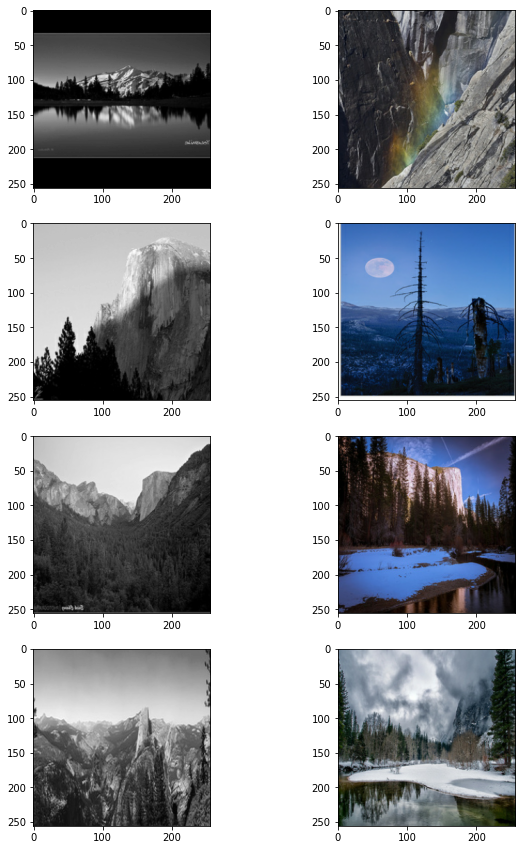

In [223]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_summer.take(4), train_winter.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)

    horse = horse[:,:,0]
    ax[i, 0].imshow(horse, cmap = "gray")
    ax[i, 1].imshow(zebra)
plt.show()


In [224]:
class ReflectionPadding2D(layers.Layer):
  
  def __init__(self, padding= (1, 1), **kwargs):
    self.padding = tuple(padding)
    super(ReflectionPadding2D, self).__init__(**kwargs)
  
  def call(self, input_tensor, mask = None):
    padding_width, padding_height = self.padding
    padding_tensor = [
        [0,0],
        [padding_width, padding_height],
        [padding_height, padding_width],
        [0,0],
    ]
    
    return tf.pad(input_tensor, padding_tensor, mode = "REFLECT")

def residual_block(
    x,
    activation,
    kernel_initializer = kernel_init,
    kernel_size = (3,3),
    strides = (1, 1),
    padding  = "valid",
    gamma_initializer = gamma_init, 
    use_bias = False,
):
  
  dim = x.shape[-1]
  input_tensor = x

  x = ReflectionPadding2D()(input_tensor)
  x = layers.Conv2D(
      dim,
      kernel_size,
      strides = strides,
      kernel_initializer = kernel_initializer,
      padding = padding,
      use_bias = use_bias,
  )(x)

  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  x = layers.add([input_tensor, x])

  return x

def downsample(
    x,
    filters,
    activation,
    kernel_initializer = kernel_init,
    kernel_size = (3, 3),
    strides = (2, 2),
    padding = "same",
    gamma_initializer = gamma_init,
    use_bias = False,
):

  x = layers.Conv2D(
      filters,
      kernel_size,
      strides = strides,
      kernel_initializer = kernel_initializer,
      padding = padding,
      use_bias = use_bias,
  )(x)

  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  if activation:
    x = activation(x)

  return x

def upsample(
    x,
    filters,
    activation,
    kernel_initializer = kernel_init,
    kernel_size = (3, 3),
    strides = (2, 2),
    padding = "same",
    gamma_initializer = gamma_init,
    use_bias = False,
):

  x = layers.Conv2DTranspose(
      filters,
      kernel_size,
      strides = strides,
      kernel_initializer = kernel_initializer,
      padding = padding,
      use_bias = use_bias,
  )(x)

  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  if activation:
    x = activation(x)

  return x
 

In [225]:
def get_resnet_generator(
    filters=64,
    input_size= (256, 256, 1),
    output_filter= 3,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):

    img_input = layers.Input(shape=input_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(output_filter, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model



In [226]:
def get_discriminator(
    filters = 64, input_size=(256,256,1), kernel_initializer = kernel_init, num_downsampling = 3, name = False
):

    img_input = layers.Input(shape= input_size, name = name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4,4),
        strides = (2, 2),
        padding = "same",
        kernel_initializer = kernel_initializer, 
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
      num_filters *= 2
      if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
      else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(input_size= (256, 256,3),output_filter= 1, name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(input_size = (256, 256, 3), name="discriminator_Y")

In [227]:
class CycleGan(keras.Model):
  def __init__(
      self,
      generator_G,
      generator_F,
      discriminator_X,
      discriminator_Y,
      lambda_cycle = 10.0,
      lambda_identity = 0.5,
  ):
    super(CycleGan, self).__init__()
    self.gen_G = generator_G
    self.gen_F = generator_F
    self.disc_X = discriminator_X
    self.disc_Y = discriminator_Y
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity
    self.built = True # added

  def call(self, inputs):
    if inputs[-1] == 1:#graycolor
      return (self.gen_G(inputs), self.disc_X(inputs))
    
    elif inputs[-1] == 3:
      return (self.gen_F(inputs), self.disc_Y(inputs))

  def compile(
      self,
      gen_G_optimizer,
      gen_F_optimizer,
      disc_X_optimizer,
      disc_Y_optimizer,
      gen_loss_fn,
      disc_loss_fn,
  ):

    super(CycleGan, self).compile()
    self.gen_G_optimizer = gen_G_optimizer
    self.gen_F_optimizer = gen_F_optimizer
    self.disc_X_optimizer = disc_X_optimizer
    self.disc_Y_optimizer = disc_Y_optimizer
    self.generator_loss_fn = gen_loss_fn
    self.discriminator_loss_fn = disc_loss_fn
    self.cycle_loss_fn = keras.losses.MeanSquaredError()



  def train_step(self, batch_data):
    real_x, real_y = batch_data
    
    with tf.GradientTape(persistent = True) as tape:
      fake_y = self.gen_G(real_x, training = True)
      fake_x = self.gen_F(real_y, training = True)

      cycle_x = self.gen_F(fake_y, training = True)
      cycle_y = self.gen_G(fake_x, training = True)
      """
      same_x = self.gen_F(real_x, training = True)
      same_y = self.gen_G(real_y, training = True)
      """
      disc_real_x = self.disc_X(real_x, training = True)
      disc_fake_x = self.disc_X(fake_x, training = True)

      disc_real_y = self.disc_Y(real_y, training = True)
      disc_fake_y = self.disc_Y(fake_y, training = True)

      gen_G_loss = self.generator_loss_fn(disc_fake_y)
      gen_F_loss = self.generator_loss_fn(disc_fake_x)

      cycle_loss_G = self.cycle_loss_fn(real_y, cycle_y)*self.lambda_cycle
      cycle_loss_F = self.cycle_loss_fn(real_x, cycle_x)*self.lambda_cycle



      total_loss_G = gen_G_loss + cycle_loss_G  
      total_loss_F = gen_F_loss + cycle_loss_F 

      # Discriminator loss
      disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
      disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

      # Get the gradients for the generators
      grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
      grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

      # Get the gradients for the discriminators
      disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
      disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

      # Update the weights of the generators
      self.gen_G_optimizer.apply_gradients(
          zip(grads_G, self.gen_G.trainable_variables)
        )
      self.gen_F_optimizer.apply_gradients(
          zip(grads_F, self.gen_F.trainable_variables)
      )

        # Update the weights of the discriminators
      self.disc_X_optimizer.apply_gradients(
         zip(disc_X_grads, self.disc_X.trainable_variables)
       )
      self.disc_Y_optimizer.apply_gradients(
           zip(disc_Y_grads, self.disc_Y.trainable_variables)
      )

      return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }



In [230]:
from locale import normalize
import time
from csv import writer

start = time.time()




class GANMonitor(keras.callbacks.Callback):
     

    test_image_path = "/content/drive/MyDrive/ColabNotebooks/test1.jpg"  

    def get_tensors_from_png(img_path):
      _read = tf.io.read_file(img_path)
      img = tf.image.decode_image(_read, channels=3)
      return img


    original_img = get_tensors_from_png(test_image_path)
    _test_img = normalize_img(original_img)
    """
    test_img=np.expand_dims(test_img, 0)
    """
    
    gray_test_img= tf.image.rgb_to_grayscale(_test_img) 

    def on_epoch_end(self, epoch, logs=None):

      test_image_path = "/content/drive/MyDrive/ColabNotebooks/test1.jpg"  


      original_img = get_tensors_from_png(test_image_path)
      _test_img = normalize_img(original_img)    
      ray_test_img= tf.image.rgb_to_grayscale(_test_img) 
      test_img = np.expand_dims(gray_test_img, 0)

      pre = CycleGan,gen_G(test_img)[0].numpy()
      pre2 = pre[1]*127.5+127.5

      plt.imshow(pre2.astype(np.uint8))
      #pre = (pre * 127.5 + 127.5).astype(np.uint8)
      #plt.imshow(pre)
    def difference_images(img1, img2):
      diff = img1 - img2
      abs_diff = np.abs(diff)
      return np.sum(abs_diff)/(256*256*3)
  
    diff = difference_images( original_img , pre2.astype(np.uint8))
    time = time.time() - start

    list_data=[epoch,start,time]
    with open('/content/drive/MyDrive/ColabNotebooks/evidence.csv', 'a', newline='') as f_object: 

          writer_object = writer(f_object)
          # Result - a writer object
          #  Pass the data in the list as an argument into the writerow() function
          writer_object.writerow(list_data)  
          # Close the file object
          f_object.close()
    # Pre-requisite - Import the writer class from the csv module

  
# The data assigned to the list 

  

In [231]:
adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
  return adv_loss_fn(tf.ones_like(fake),fake)

def discriminator_loss_fn(real, fake):
  real_loss = adv_loss_fn(tf.ones_like(real), real)
  fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
  return (real_loss+fake_loss)*0.5
cycle_gan_model = CycleGan(
    generator_G = gen_G, generator_F = gen_F,  discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)



In [ ]:
plotter = GANMonitor()
path = "/content/drive/MyDrive/ColabNotebooks/color_weights/{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath= path, verbose=1,
                                save_best_only=False, save_weights_only=True, mode='auto',save_freq = "epoch")

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_summer, train_winter)),
    epochs=50,
    callbacks=[plotter, model_checkpoint_callback],
)


Epoch 1/50
 27/962 [..............................] - ETA: 5:59 - G_loss: 1.5152 - F_loss: 1.1682 - D_X_loss: 0.2032 - D_Y_loss: 0.1837